# Data Simulation

In [88]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch
from torch.utils.data import Dataset
from tqdm import tqdm

In [76]:
class TwoArmLinkDataset(Dataset):
	def __init__(self, n_tasks=1500, n_episode=150, n_timesteps=10) -> None:
		super().__init__()
		self.x_0 = []
		self.u = []
		self.x = []
		self.z = []
		l_of_tasks = np.random.normal(loc=1, scale=0.3, size=(n_tasks,2))
		for i in tqdm(range(n_tasks)):
			l = l_of_tasks[i]
			for j in range(n_episode):
				x_0, u, x, z = TwoArmLinkDataset.generate_episode(l, n_timesteps)
				self.x_0.append(x_0)
				self.u.append(u)
				self.x.append(x)
				self.z.append(z)

	def __getitem__(self, index):
		x_0 = self.x_0[index]
		u = self.u[index]
		x = self.x[index]
		z = self.z[index]
		sample = {
			"init_pos": torch.tensor(x_0),
			"control": torch.tensor(u),
			"true_pos": torch.tensor(x),
			"noisy_pos": torch.tensor(z),
		}
		return sample

	def __len__(self):
		return len(self.x_0)

	@staticmethod
	def generate_episode(l, n_timesteps):
		def x_of_q(q, l):
			# q: array (2,) containing the two angles
			# l: array (2,) containing the limb lengths 
			x = l[0] * np.cos(q[0]) + l[1] * np.cos(q[0] + q[1])
			y = l[0] * np.sin(q[0]) + l[1] * np.sin(q[0] + q[1])
			return np.array([x, y])
		q_0 = np.random.uniform(low= -np.pi, high= np.pi, size=2)
		x_0 = x_of_q(q_0,l=l)
		u = np.random.randn(2, n_timesteps)
		q = u.cumsum(axis=1) + q_0.reshape(-1,1)
		x = x_of_q(q, l=l)
		z = x + np.random.normal(0, scale=0.001, size=(2, n_timesteps))
		return x_0, u, x, z

In [77]:
dataset = TwoArmLinkDataset()

100%|██████████| 1500/1500 [00:17<00:00, 84.69it/s] 


In [78]:
dir(dataset)

['__add__',
 '__class__',
 '__class_getitem__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__orig_bases__',
 '__parameters__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_is_protocol',
 'generate_episode',
 'u',
 'x',
 'x_0',
 'z']

In [72]:
torch.save(dataset, 'two_arm_link_dataset')

In [81]:
dataset[0]

{'init_pos': tensor([-0.7607, -0.2701], dtype=torch.float64),
 'control': tensor([[-0.2180, -0.3252, -1.2778, -1.5935, -0.8869,  0.9012, -0.4094,  0.3615,
          -1.2734, -0.8315],
         [ 1.5497, -0.0686,  0.8059,  1.9168,  1.0168,  1.1644, -0.2690, -1.3127,
          -0.2142,  0.1618]], dtype=torch.float64),
 'true_pos': tensor([[-1.0318, -0.8824,  0.2500,  1.2943,  0.8504,  0.7992,  0.7970,  1.1453,
           0.5651, -0.3875],
         [ 0.2449,  0.5508,  1.2350,  0.2021, -0.6153,  0.0369, -0.2219,  0.2395,
          -1.0882, -1.1192]], dtype=torch.float64),
 'noisy_pos': tensor([[-1.0319, -0.8820,  0.2501,  1.2941,  0.8501,  0.7976,  0.7963,  1.1453,
           0.5641, -0.3853],
         [ 0.2470,  0.5515,  1.2349,  0.2032, -0.6133,  0.0368, -0.2208,  0.2396,
          -1.0883, -1.1180]], dtype=torch.float64)}

In [79]:
x = dataset[0]['true_pos']
z = dataset[0]['noisy_pos']

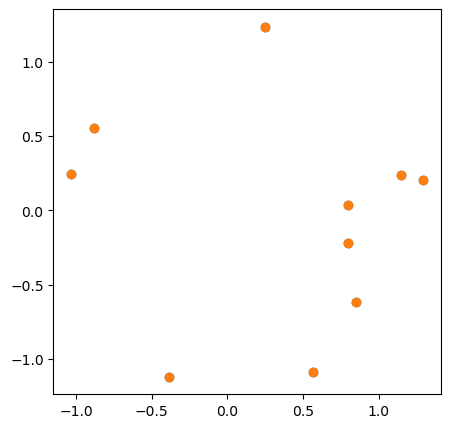

In [85]:
plt.figure(figsize=(5,5))
plt.scatter(*x.numpy())
plt.scatter(*z.numpy())